# KILT-5-1-HandsOnAnalysis_evaluationOnPositionContextsize

- Evalutaion on FiD with Random Sampling shows higher EM with extra random-passages
    - Need to check random-sampling reveals stronger token unit boundary in the passages
    - Check out query and passages 

In [1]:
from cycler import cycler
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pathlib
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from util import utils
import re

In [2]:
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]


light_palette = np.array(raw_light_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255

Light mode palette


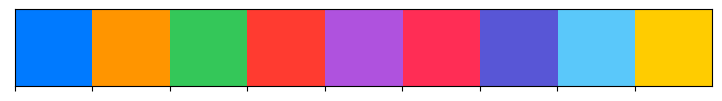

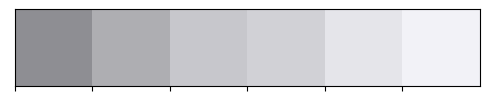

In [3]:
print('Light mode palette')
sns.palplot(light_palette)
sns.palplot(gray_light_palette)

In [4]:
# cmap 수정
mpl.rcParams['axes.prop_cycle'] = cycler('color',light_palette)
# 해상도 조정
mpl.rcParams['figure.dpi'] = 200
# ax의 우측과 상단 지우기
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

### FiD turned out to be invariant of position (in both BM25, Random Sample negatives)
- Select all the result files with __pos1__ (fixed)
    - Only need pos1 files
- Select corresponding input files
- Matching them 
    
```format

columns
    'id' : id from kilt_bm25_nq_dev_pos1.json
        - kilt_bm25_nq_dev_pos1.json
            - post-processed from nq-dev-multikilt.json
            - Path : /data/philhoon-relevance/FiD/open_domain_data/NQ_KILT_BM25/kilt_bm25_nq_dev_pos1.json
            - 2539 instances
            - ids (generated)
        - nq-dev-multikilt.json
            - original KILT-nq-dev
            - Path : /data/philhoon-relevance/KILT/kilt-dpr-retrieval/nq-dev-multikilt.json
            - 2837 instances 
            - no ids
    'question' : query text from kilt_bm25_nq_dev_pos1.json
    'answers' : lst of answers from kilt_bm25_nq_dev_pos1.json
    'ctxs' : 'ctxs' from kilt_bm25_nq_dev_pos1.json
        - ctxs[0] : gold context (answer)
        - ctxs[1 ~5] : negative context
    
    'em_pattern' : numbers 1 if answer matches the answer text in answer_lst, 0 otherwise
        - Using final_outputs.txt
        - Path : /data/philhoon-relevance/FiD/results/KILT_BM25_NQ/kilt_bm25_nq_dev_pos1_context{pos} (pos 1~5)
    'inference' : incremental inference result from final_outputs.txt 
        - Using final_outputs.txt
        - Path : /data/philhoon-relevance/FiD/results/KILT_BM25_NQ/kilt_bm25_nq_dev_pos1_context{pos} (pos 1~5)
    'cumulative_em' : cumulative_em based on em_pattern
    'conversion' : number of conversion due to negative context
    
````
    - input file path : path = '/data/philhoon-relevance/FiD/open_domain_data/NQ_KILT_RANDOM/'
    - result file path : path = '/data/philhoon-relevance/FiD/results/KILT_RANDOM_NQ'
    
    - Testing with positive context on 1st 
        '/data/philhoon-relevance/FiD/open_domain_data/NQ_KILT_RANDOM/kilt_rand_nq_dev_pos1.json'

## KILT BM25 NQ negative (from DPR)

In [5]:
pos = 1
sample_size = 5
# kilt_nq_dev_file = '/data/philhoon-relevance/KILT/kilt-dpr-retrieval/nq-dev-multikilt.json'
kilt_nq_dev_file = f'/data/philhoon-relevance/FiD/open_domain_data/NQ_KILT_BM25/kilt_bm25_nq_dev_pos{pos}.json'
fid_result_path = f'/data/philhoon-relevance/FiD/results/KILT_BM25_NQ/'
output_file_path = f'/data/philhoon-relevance/FiD/results/KILT_BM25_NQ/incremental_result/pos{pos}_ctx{sample_size}.json'
output_txt_path = f'/data/philhoon-relevance/FiD/results/KILT_BM25_NQ/incremental_result/pos{pos}_ctx{sample_size}.txt'
path = pathlib.Path(fid_result_path)

## KILT Random Sampling NQ negative 

In [6]:
# path = '/data/philhoon-relevance/FiD/results/KILT_RANDOM_NQ'

In [7]:
# files = path.glob(pattern)
# pprint(list(files))
# test = '/data/philhoon-relevance/FiD/results/KILT_BM25_NQ/kilt_bm25_nq_dev_pos1_context2/final_output.txt'

In [8]:
# sample_size = 5
# for ctx in range(pos, sample_size+1):
#     file_pattern = f'./kilt_bm25_nq_dev_pos{pos}_context{ctx}/final_output.txt'
#     file = list(path.glob(file_pattern))
#     test = file[0] 
#     print(test)

### merge final_output.txt files

In [9]:
def merge_output(path, sample_size):
    id_lst = []
    inference_lst = []
    em_lst = []
    
    for ctx in range(pos, sample_size+1):
        file_pattern = f'./kilt_bm25_nq_dev_pos{pos}_context{ctx}/final_output.txt'
        print(file_pattern)
        output_file = list(path.glob(file_pattern))
        test = output_file[0]
        df = pd.read_csv(test, sep = '\t', header=None)
        df.columns = ['id','inference','em']

        if not id_lst:
            id_lst = df.id.to_list()
        inference_lst.append(df.inference.to_list())
        em_lst.append(df.em.to_list())
    
    return id_lst, inference_lst, em_lst
    

In [10]:
id_, infer_, em_ = merge_output(path, sample_size)

./kilt_bm25_nq_dev_pos1_context1/final_output.txt
./kilt_bm25_nq_dev_pos1_context2/final_output.txt
./kilt_bm25_nq_dev_pos1_context3/final_output.txt
./kilt_bm25_nq_dev_pos1_context4/final_output.txt
./kilt_bm25_nq_dev_pos1_context5/final_output.txt


In [18]:
# print(infer_)

In [ ]:
def get_em_result(em_zip):
    cul_cnt = 0
    cul_em = []
    conversion = []
    for em in em_zip:
        if '1' in em:
            cul_em.append('1')
            cul_cnt += 1
        else:
            cul_em.append('0')

        conversion.append(len(re.findall(r'10', em)))
    
    return cul_em, conversion, cul_cnt

In [19]:
# em_pattern
em_zip = list(map(lambda line: ''.join(map(lambda s: str(1) if s else str(0), line)), zip(*em_)))

# inference
infer_zip = list(map(list, zip(*infer_)))

# cumulative_em, conversion
cul_em_lst, conversion_lst, cul_cnt = get_em_result(em_zip)

In [ ]:
# result = {}
# for query_id, em_pattern, inference, conversion, cumulative_em in zip(id_, em_zip, infer_zip, conversion_lst, cul_em_lst):
#     template = {
#         'em_pattern' : em_pattern,
#         'inference' : inference,
#         'conversion' : conversion,
#         'cumulative_em' : cumulative_em
#     }
#     result[query_id] = template

In [ ]:
def get_merged_result(id_, em_zip, infer_zip, conversion_lst, cul_em_lst):
    result = {}
    for query_id, em_pattern, inference, conversion, cumulative_em in zip(id_, em_zip, infer_zip, conversion_lst, cul_em_lst):
        template = {
            'em_pattern' : em_pattern,
            'inference' : inference,
            'conversion' : conversion,
            'cumulative_em' : cumulative_em
        }
        result[str(query_id)] = template
    return result

In [ ]:
result = get_merged_result(id_, em_zip, infer_zip, conversion_lst, cul_em_lst)

In [ ]:
# result

### merge above outputs to orignal file

In [ ]:
nq_dev_format = utils.open_json(kilt_nq_dev_file)

In [ ]:
def merge_with_input(nq_dev_format, result):
    for dev_example in nq_dev_format:
        if dev_example['id'] in result.keys():
            dev_example['em_pattern'] = result[dev_example['id']]['em_pattern']

            dev_example['inference'] = result[dev_example['id']]['inference']
            dev_example['conversion'] = result[dev_example['id']]['conversion']
            dev_example['cumulative_em'] = result[dev_example['id']]['cumulative_em']
        else:
            print('ID not exist. Mathcing ID required')
    return nq_dev_format

In [ ]:
final_output = merge_with_input(nq_dev_format, result)

In [ ]:
utils.save_json(final_output, output_file_path)

In [ ]:
cul_cnt = 0
for ins in final_output:
    cul_cnt += int(ins['cumulative_em'])
cul_score = cul_cnt/len(final_output)
output_string = f'Out of {len(final_output)} instances; {cul_cnt} are incrementally correct : {cul_score} in EM'

In [ ]:
output_string

In [ ]:
with open(output_txt_path, "w") as file:
    file.write(output_string)